In [1]:
import os
import glob
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

def split_csv  (csv_path,
                out_csv_path,
                test_size=0.125,
                val_size=0.125,
                strat_col_preference=("true_idx", "true_class"),
                random_seed=42,
                plot=True):

    if not os.path.exists(csv_path):
        raise RuntimeError(f"CSV not found: {csv_path}")

    df = pd.read_csv(csv_path)
    n = df.shape[0]
    print(f"Loaded CSV {csv_path}: {n} rows")

    strat_labels = None
    label_names = None
    used_strat_col = None
    if strat_col_preference[0] in df.columns:
        used_strat_col = strat_col_preference[0]
        strat_labels = df[used_strat_col].to_numpy()
        label_names = np.unique(strat_labels).astype(str).tolist()
        print(f"Using '{used_strat_col}' for stratification")
    elif strat_col_preference[1] in df.columns:
        used_strat_col = strat_col_preference[1]
        strat_labels, uniques = pd.factorize(df[used_strat_col])
        label_names = uniques.tolist()
        print(f"Using '{used_strat_col}' (factorized) for stratification")
    else:
        raise RuntimeError("CSV must contain one of the stratification columns: " + ",".join(strat_col_preference))

    val_fraction_of_remaining = val_size / (1.0 - test_size)

    sss_test = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_seed)
    remaining_idx, test_idx = next(sss_test.split(np.zeros(n), strat_labels))

    if val_size and val_size > 0:
        sss_val = StratifiedShuffleSplit(n_splits=1, test_size=val_fraction_of_remaining, random_state=random_seed + 1)
        rel_train_rel, val_rel = next(sss_val.split(np.zeros(len(remaining_idx)), strat_labels[remaining_idx]))
        train_idx = remaining_idx[rel_train_rel]
        val_idx = remaining_idx[val_rel]
    else:
        train_idx = remaining_idx
        val_idx = np.array([], dtype=int)

    split_series = pd.Series(index=np.arange(n), dtype=object)
    split_series.iloc[train_idx] = "train"
    split_series.iloc[val_idx] = "val"
    split_series.iloc[test_idx] = "test"

    df_out = df.copy()
    df_out["detect_split"] = split_series.values

    os.makedirs(os.path.dirname(out_csv_path) or ".", exist_ok=True)
    df_out.to_csv(out_csv_path, index=False)

    indices = {"train_idx": train_idx.tolist(), "val_idx": val_idx.tolist(), "test_idx": test_idx.tolist()}
    meta_path = os.path.splitext(out_csv_path)[0] + "_split_indices.json"
    with open(meta_path, "w") as f:
        json.dump(indices, f, indent=2)

    print(f"Wrote split CSV to {out_csv_path} and indices to {meta_path}")
    print(f"Counts -> train: {len(train_idx)}, val: {len(val_idx)}, test: {len(test_idx)}")

    if plot:
        out_dir = os.path.dirname(out_csv_path) or "."
        os.makedirs(out_dir, exist_ok=True)
        label_codes = np.unique(strat_labels)

        def counts_for_indices(idxs):
            if len(idxs) == 0:
                return np.zeros(len(label_codes), dtype=int)
            vals = strat_labels[idxs]
            positions = {v: i for i, v in enumerate(label_codes)}
            counts = np.zeros(len(label_codes), dtype=int)
            for v in vals:
                counts[positions[v]] += 1
            return counts

        for split_name, idxs in [("train", train_idx), ("val", val_idx), ("test", test_idx)]:
            counts = counts_for_indices(idxs)
            fig, ax = plt.subplots()
            x = np.arange(len(label_codes))
            ax.bar(x, counts)
            if label_names and len(label_names) == len(label_codes):
                xticks = [str(l) for l in label_names]
            else:
                xticks = [str(l) for l in label_codes]

            if len(xticks) <= 50:
                ax.set_xticks(x)
                ax.set_xticklabels(xticks, rotation=90, fontsize=6)
            else:
                step = max(1, len(xticks) // 40)
                ax.set_xticks(x[::step])
                ax.set_xticklabels([xticks[i] for i in range(0, len(xticks), step)], rotation=90, fontsize=6)

            ax.set_xlabel(used_strat_col)
            ax.set_ylabel("count")
            ax.set_title(f"Distribution of {used_strat_col} in {split_name} (n={len(idxs)})")
            fig.tight_layout()

            out_png = os.path.join(out_dir, f"split_hist_{split_name}_{used_strat_col}.png")
            fig.savefig(out_png, dpi=150)
            plt.show()
            plt.close(fig)
            print(f"Saved histogram: {out_png}")

    return out_csv_path


def generate_detection_dataset( img_size,
                                detector,
                                set_name,
                                split_csv_path,
                                data_dir=None,
                                out_dir=None,
                                write_labels=False):
    if data_dir is None:
        data_dir = f"../03-ExtractCharacteristics/data/characteristics/{img_size}"
    if out_dir is None:
        out_dir = f"./detect_dataset/{img_size}x{img_size}"

    if not os.path.exists(split_csv_path):
        raise RuntimeError(f"Split CSV not found: {split_csv_path}")

    df_split = pd.read_csv(split_csv_path)
    if "detect_split" not in df_split.columns:
        raise RuntimeError("split_csv must contain 'detect_split' column with values train/val/test")

    adv_pattern = os.path.join(data_dir, f"{set_name}_*_{detector}_{img_size}_adv.npy")
    clean_pattern = os.path.join(data_dir, f"{set_name}_*_{detector}_{img_size}.npy")

    adv_files = sorted(glob.glob(adv_pattern))
    clean_files = sorted([f for f in glob.glob(clean_pattern) if not f.endswith("_adv.npy")])

    if not adv_files:
        raise RuntimeError("No adv files found. Expect files like imagenet_fgsm_LayerPFS_32_adv.npy in data_dir.")

    def attack_from_filename(fn):
        base = os.path.basename(fn)
        parts = base.split("_")
        return parts[1].lower() if len(parts) >= 3 else None

    adv_map = {attack_from_filename(f): f for f in adv_files}
    clean_map = {attack_from_filename(f): f for f in clean_files}

    available_attacks = sorted(list(adv_map.keys()))
    print("Detected adv attacks:", available_attacks)

    missing_cleans = [a for a in available_attacks if a not in clean_map]
    if missing_cleans:
        raise RuntimeError(f"Missing per-attack clean files for attacks: {missing_cleans}.")

    X_clean_per_attack = {}
    X_adv_per_attack = {}
    n_rows = None
    for atk in available_attacks:
        clean_fn = clean_map[atk]
        adv_fn = adv_map[atk]
        Xc = np.load(clean_fn)
        Xa = np.load(adv_fn)
        if Xc.shape[0] != Xa.shape[0]:
            raise RuntimeError(f"Row mismatch for attack '{atk}': clean {clean_fn} has {Xc.shape[0]} rows, adv {adv_fn} has {Xa.shape[0]} rows.")
        X_clean_per_attack[atk] = Xc
        X_adv_per_attack[atk] = Xa
        print(f"Loaded attack '{atk}' -> clean: {os.path.basename(clean_fn)}, adv: {os.path.basename(adv_fn)}, rows: {Xc.shape[0]}")
        if n_rows is None:
            n_rows = Xc.shape[0]
        elif n_rows != Xc.shape[0]:
            raise RuntimeError(f"Different row counts across attacks (unexpected). Attack {atk} has {Xc.shape[0]} rows, expected {n_rows}.")

    if df_split.shape[0] != n_rows:
        raise RuntimeError(f"Split CSV row count ({df_split.shape[0]}) != number of rows in arrays ({n_rows}). They must match.")

    train_idx = df_split.index[df_split["detect_split"] == "train"].to_numpy()
    val_idx = df_split.index[df_split["detect_split"] == "val"].to_numpy()
    test_idx = df_split.index[df_split["detect_split"] == "test"].to_numpy()

    print(f"Using split counts -> train: {len(train_idx)}, val: {len(val_idx)}, test: {len(test_idx)}")

    def ensure_dir(p):
        os.makedirs(p, exist_ok=True)

    def save_np(p, arr):
        np.save(p, arr)

    def save_json(p, obj):
        with open(p, "w") as f:
            json.dump(obj, f, indent=2)

    ensure_dir(out_dir)

    split_metadata_all = {}

    def concat_pair(a, b):
        if a is None or a.size == 0:
            return b.copy() if b is not None else np.empty((0, 0))
        if b is None or b.size == 0:
            return a.copy()
        return np.vstack([a, b])

    for atk in available_attacks:
        print(f"Processing attack '{atk}'...")
        atk_dir = os.path.join(out_dir, atk)
        ensure_dir(atk_dir)

        Xc = X_clean_per_attack[atk]
        Xa = X_adv_per_attack[atk]

        Xc_train_raw = Xc[train_idx]
        Xa_train_raw = Xa[train_idx]

        Xc_val_raw = Xc[val_idx] if len(val_idx) else np.empty((0, Xc_train_raw.shape[1]))
        Xa_val_raw = Xa[val_idx] if len(val_idx) else np.empty((0, Xa_train_raw.shape[1]))

        Xc_test_raw = Xc[test_idx]
        Xa_test_raw = Xa[test_idx]

        X_train_raw = concat_pair(Xc_train_raw, Xa_train_raw)
        X_val_raw = concat_pair(Xc_val_raw, Xa_val_raw)

        save_np(os.path.join(atk_dir, "train_raw.npy"), X_train_raw)
        save_np(os.path.join(atk_dir, "val_raw.npy"), X_val_raw)
        save_np(os.path.join(atk_dir, "test_clean_raw.npy"), Xc_test_raw)
        save_np(os.path.join(atk_dir, "test_adv_raw.npy"), Xa_test_raw)

        if write_labels:
            train_labels = np.concatenate([np.zeros(Xc_train_raw.shape[0], dtype=np.uint8), np.ones(Xa_train_raw.shape[0], dtype=np.uint8)])
            val_labels = np.concatenate([np.zeros(Xc_val_raw.shape[0], dtype=np.uint8), np.ones(Xa_val_raw.shape[0], dtype=np.uint8)])
            save_np(os.path.join(atk_dir, "train_labels.npy"), train_labels)
            save_np(os.path.join(atk_dir, "val_labels.npy"), val_labels)

        meta = {
            "train_idx": train_idx.tolist(),
            "val_idx": val_idx.tolist(),
            "test_idx": test_idx.tolist(),
            "n_train_pairs": int(Xc_train_raw.shape[0]),
            "n_val_pairs": int(Xc_val_raw.shape[0]),
            "n_test_pairs": int(Xc_test_raw.shape[0])
        }
        split_metadata_all[atk] = meta
        save_json(os.path.join(atk_dir, "split_metadata.json"), meta)

        print(f"Saved raw arrays for attack '{atk}' in {atk_dir} (train: {X_train_raw.shape[0]} rows, val: {X_val_raw.shape[0]} rows, test_clean: {Xc_test_raw.shape[0]}, test_adv: {Xa_test_raw.shape[0]})")


    save_json(os.path.join(out_dir, "split_metadata_all_attacks.json"), split_metadata_all)

    print("Done. RAW splits saved under:", out_dir)
    return out_dir

Matplotlib is building the font cache; this may take a moment.


In [2]:
from numpy.lib.format import open_memmap

def generate_detection_dataset( img_size,
                                detector,
                                set_name,
                                split_csv_path,
                                data_dir=None,
                                out_dir=None,
                                write_labels=False,
                                memmap_threshold_bytes=1_000_000_000):
    if data_dir is None:
        data_dir = f"../03-ExtractCharacteristics/data/characteristics/{img_size}"
    if out_dir is None:
        out_dir = f"./detect_dataset/{img_size}x{img_size}"

    if not os.path.exists(split_csv_path):
        raise RuntimeError(f"Split CSV not found: {split_csv_path}")

    df_split = pd.read_csv(split_csv_path)
    if "detect_split" not in df_split.columns:
        raise RuntimeError("split_csv must contain 'detect_split' column with values train/val/test")

    adv_pattern = os.path.join(data_dir, f"{set_name}_*_{detector}_{img_size}_adv.npy")
    clean_pattern = os.path.join(data_dir, f"{set_name}_*_{detector}_{img_size}.npy")

    adv_files = sorted(glob.glob(adv_pattern))
    clean_files = sorted([f for f in glob.glob(clean_pattern) if not f.endswith("_adv.npy")])

    if not adv_files:
        raise RuntimeError("No adv files found. Expect files like imagenet_fgsm_LayerPFS_32_adv.npy in data_dir.")

    def attack_from_filename(fn):
        base = os.path.basename(fn)
        parts = base.split("_")
        return parts[1].lower() if len(parts) >= 3 else None

    adv_map = {attack_from_filename(f): f for f in adv_files}
    clean_map = {attack_from_filename(f): f for f in clean_files}

    available_attacks = sorted(list(adv_map.keys()))
    print("Detected adv attacks:", available_attacks)

    missing_cleans = [a for a in available_attacks if a not in clean_map]
    if missing_cleans:
        raise RuntimeError(f"Missing per-attack clean files for attacks: {missing_cleans}.")

    X_clean_per_attack = {}
    X_adv_per_attack = {}
    n_rows = None
    for atk in available_attacks:
        clean_fn = clean_map[atk]
        adv_fn = adv_map[atk]
        Xc = np.load(clean_fn, mmap_mode='r')
        Xa = np.load(adv_fn, mmap_mode='r')
        if Xc.shape[0] != Xa.shape[0]:
            raise RuntimeError(f"Row mismatch for attack '{atk}': clean {clean_fn} has {Xc.shape[0]} rows, adv {adv_fn} has {Xa.shape[0]} rows.")
        X_clean_per_attack[atk] = Xc
        X_adv_per_attack[atk] = Xa
        print(f"Loaded attack '{atk}' -> clean: {os.path.basename(clean_fn)}, adv: {os.path.basename(adv_fn)}, rows: {Xc.shape[0]}")
        if n_rows is None:
            n_rows = Xc.shape[0]
        elif n_rows != Xc.shape[0]:
            raise RuntimeError(f"Different row counts across attacks (unexpected). Attack {atk} has {Xc.shape[0]} rows, expected {n_rows}.")

    if df_split.shape[0] != n_rows:
        raise RuntimeError(f"Split CSV row count ({df_split.shape[0]}) != number of rows in arrays ({n_rows}). They must match.")

    train_idx = df_split.index[df_split["detect_split"] == "train"].to_numpy()
    val_idx = df_split.index[df_split["detect_split"] == "val"].to_numpy()
    test_idx = df_split.index[df_split["detect_split"] == "test"].to_numpy()

    print(f"Using split counts -> train: {len(train_idx)}, val: {len(val_idx)}, test: {len(test_idx)}")

    def ensure_dir(p):
        os.makedirs(p, exist_ok=True)

    def save_json(p, obj):
        with open(p, "w") as f:
            json.dump(obj, f, indent=2)

    ensure_dir(out_dir)

    split_metadata_all = {}

    def chunked_copy_to_memmap(src_arr, idxs, dest_memmap, dest_offset, chunk_max_bytes=100_000_000):
        if len(idxs) == 0:
            return 0
        feat_dim = src_arr.shape[1]
        max_chunk_rows = max(1, int(chunk_max_bytes / (feat_dim * 4)))
        copied = 0
        for start in range(0, len(idxs), max_chunk_rows):
            sel = idxs[start:start + max_chunk_rows]
            dest_memmap[dest_offset + copied : dest_offset + copied + len(sel), :] = src_arr[sel]
            copied += len(sel)
        return copied

    for atk in available_attacks:
        print(f"Processing attack '{atk}'...")
        atk_dir = os.path.join(out_dir, atk)
        ensure_dir(atk_dir)

        Xc = X_clean_per_attack[atk]
        Xa = X_adv_per_attack[atk]

        Xc_test_raw = np.array(Xc[test_idx])
        Xa_test_raw = np.array(Xa[test_idx])

        Xc_train_idx = train_idx
        Xa_train_idx = train_idx
        n_c_train = len(Xc_train_idx)
        n_a_train = len(Xa_train_idx)
        total_train = n_c_train + n_a_train

        feat_dim = Xc.shape[1]
        est_bytes_train = total_train * feat_dim * 4

        train_out_path = os.path.join(atk_dir, "train_raw.npy")

        if total_train == 0:
            np.save(train_out_path, np.empty((0, feat_dim), dtype=np.float32))
            print(f"Saved empty train_raw for attack '{atk}'")
        elif est_bytes_train > memmap_threshold_bytes:
            mm = open_memmap(train_out_path, mode='w+', dtype=np.float32, shape=(total_train, feat_dim))
            pos = 0
            pos += chunked_copy_to_memmap(Xc, Xc_train_idx, mm, pos)
            pos += chunked_copy_to_memmap(Xa, Xa_train_idx, mm, pos)

            del mm
            print(f"[memmap] Saved train_raw.npy (memmap) for attack '{atk}' rows={total_train}")
        else:
            Xc_train_raw = np.array(Xc[Xc_train_idx])
            Xa_train_raw = np.array(Xa[Xa_train_idx])
            X_train_raw = np.vstack([Xc_train_raw, Xa_train_raw])
            np.save(train_out_path, X_train_raw)
            print(f"Saved train_raw.npy (in-memory) for attack '{atk}' rows={X_train_raw.shape[0]}")

        n_c_val = len(val_idx)
        n_a_val = len(val_idx)
        total_val = n_c_val + n_a_val
        val_out_path = os.path.join(atk_dir, "val_raw.npy")

        if total_val == 0:
            np.save(val_out_path, np.empty((0, feat_dim), dtype=np.float32))
            print(f"Saved empty val_raw for attack '{atk}'")
        else:
            est_bytes_val = total_val * feat_dim * 4
            if est_bytes_val > memmap_threshold_bytes:
                mmv = open_memmap(val_out_path, mode='w+', dtype=np.float32, shape=(total_val, feat_dim))
                pos = 0
                pos += chunked_copy_to_memmap(Xc, val_idx, mmv, pos)
                pos += chunked_copy_to_memmap(Xa, val_idx, mmv, pos)
                del mmv
                print(f"[memmap] Saved val_raw.npy (memmap) for attack '{atk}' rows={total_val}")
            else:
                Xc_val_raw = np.array(Xc[val_idx]) if len(val_idx) else np.empty((0, feat_dim), dtype=np.float32)
                Xa_val_raw = np.array(Xa[val_idx]) if len(val_idx) else np.empty((0, feat_dim), dtype=np.float32)
                X_val_raw = np.vstack([Xc_val_raw, Xa_val_raw])
                np.save(val_out_path, X_val_raw)
                print(f"Saved val_raw.npy (in-memory) for attack '{atk}' rows={X_val_raw.shape[0]}")

        np.save(os.path.join(atk_dir, "test_clean_raw.npy"), Xc_test_raw.astype(np.float32))
        np.save(os.path.join(atk_dir, "test_adv_raw.npy"),  Xa_test_raw.astype(np.float32))

        if write_labels:
            train_labels = np.concatenate([np.zeros(n_c_train, dtype=np.uint8), np.ones(n_a_train, dtype=np.uint8)])
            val_labels = np.concatenate([np.zeros(n_c_val, dtype=np.uint8), np.ones(n_a_val, dtype=np.uint8)])
            np.save(os.path.join(atk_dir, "train_labels.npy"), train_labels)
            np.save(os.path.join(atk_dir, "val_labels.npy"), val_labels)

        meta = {
            "train_idx": train_idx.tolist(),
            "val_idx": val_idx.tolist(),
            "test_idx": test_idx.tolist(),
            "n_train_pairs": int(n_c_train),
            "n_val_pairs": int(n_c_val),
            "n_test_pairs": int(Xc_test_raw.shape[0])
        }
        split_metadata_all[atk] = meta
        save_json(os.path.join(atk_dir, "split_metadata.json"), meta)

        print(f"Saved arrays for attack '{atk}' in {atk_dir}'")

    save_json(os.path.join(out_dir, "split_metadata_all_attacks.json"), split_metadata_all)

    print("Done. RAW splits saved under:", out_dir)
    return out_dir


Loaded CSV ../02-AdvGenerate/Evaluate/common_success_details.csv: 649 rows
Using 'true_idx' for stratification
Wrote split CSV to ./splits/common_success_detect_split.csv and indices to ./splits/common_success_detect_split_split_indices.json
Counts -> train: 486, val: 81, test: 82


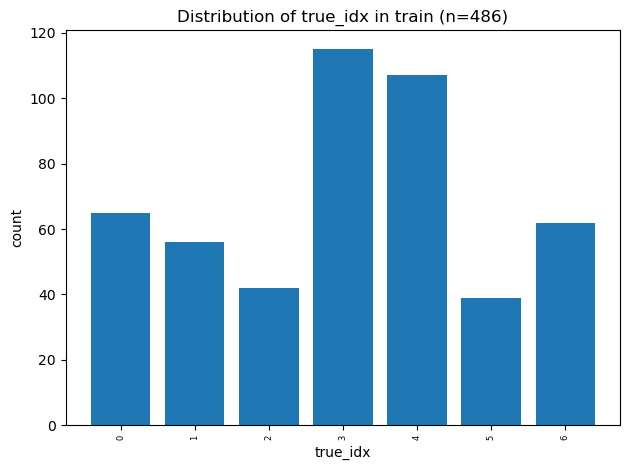

Saved histogram: ./splits\split_hist_train_true_idx.png


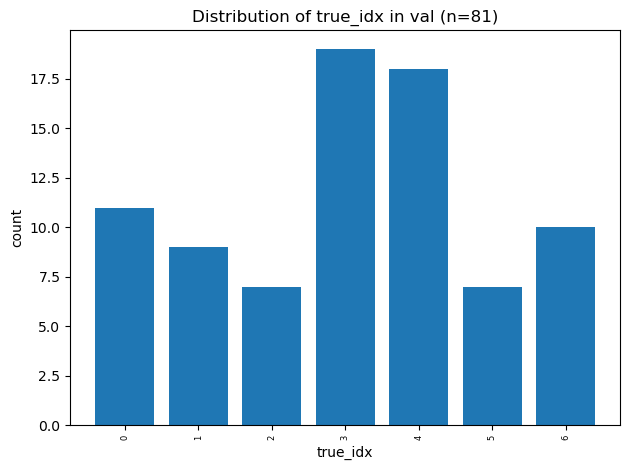

Saved histogram: ./splits\split_hist_val_true_idx.png


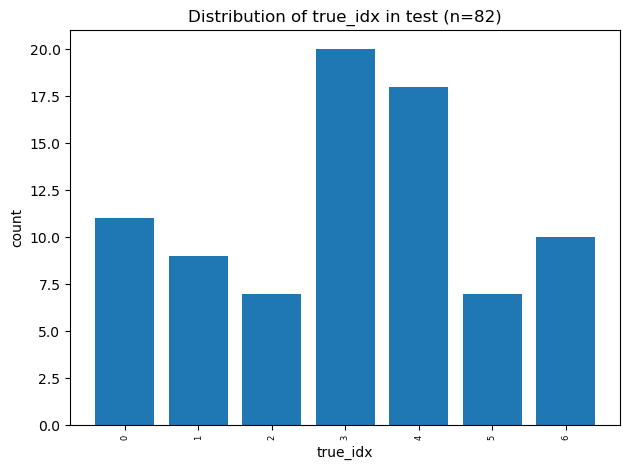

Saved histogram: ./splits\split_hist_test_true_idx.png


'./splits/common_success_detect_split.csv'

In [3]:
split_csv( '../02-AdvGenerate/Evaluate/common_success_details.csv',
           './splits/common_success_detect_split.csv',
           test_size=0.125, val_size=0.125)


In [8]:
generate_detection_dataset( img_size=32,
                            detector="LayerPFS",
                            set_name="inat",
                            split_csv_path="./splits/common_success_detect_split.csv",
                            data_dir=None,
                            out_dir=None,
                            write_labels=True)

Detected adv attacks: ['bim', 'cw', 'df', 'fgsm', 'pgd']
Loaded attack 'bim' -> clean: inat_bim_LayerPFS_32.npy, adv: inat_bim_LayerPFS_32_adv.npy, rows: 649
Loaded attack 'cw' -> clean: inat_cw_LayerPFS_32.npy, adv: inat_cw_LayerPFS_32_adv.npy, rows: 649
Loaded attack 'df' -> clean: inat_df_LayerPFS_32.npy, adv: inat_df_LayerPFS_32_adv.npy, rows: 649
Loaded attack 'fgsm' -> clean: inat_fgsm_LayerPFS_32.npy, adv: inat_fgsm_LayerPFS_32_adv.npy, rows: 649
Loaded attack 'pgd' -> clean: inat_pgd_LayerPFS_32.npy, adv: inat_pgd_LayerPFS_32_adv.npy, rows: 649
Using split counts -> train: 486, val: 81, test: 82
Processing attack 'bim'...
Saved train_raw.npy (in-memory) for attack 'bim' rows=972
Saved val_raw.npy (in-memory) for attack 'bim' rows=162
Saved arrays for attack 'bim' in ./detect_dataset/32x32\bim'
Processing attack 'cw'...
Saved train_raw.npy (in-memory) for attack 'cw' rows=972
Saved val_raw.npy (in-memory) for attack 'cw' rows=162
Saved arrays for attack 'cw' in ./detect_dataset/

'./detect_dataset/32x32'

In [9]:
generate_detection_dataset( img_size=64,
                            detector="LayerPFS",
                            set_name="inat",
                            split_csv_path="./splits/common_success_detect_split.csv",
                            data_dir=None,
                            out_dir=None,
                            write_labels=True)

Detected adv attacks: ['bim', 'cw', 'df', 'fgsm', 'pgd']
Loaded attack 'bim' -> clean: inat_bim_LayerPFS_64.npy, adv: inat_bim_LayerPFS_64_adv.npy, rows: 649
Loaded attack 'cw' -> clean: inat_cw_LayerPFS_64.npy, adv: inat_cw_LayerPFS_64_adv.npy, rows: 649
Loaded attack 'df' -> clean: inat_df_LayerPFS_64.npy, adv: inat_df_LayerPFS_64_adv.npy, rows: 649
Loaded attack 'fgsm' -> clean: inat_fgsm_LayerPFS_64.npy, adv: inat_fgsm_LayerPFS_64_adv.npy, rows: 649
Loaded attack 'pgd' -> clean: inat_pgd_LayerPFS_64.npy, adv: inat_pgd_LayerPFS_64_adv.npy, rows: 649
Using split counts -> train: 486, val: 81, test: 82
Processing attack 'bim'...
[memmap] Saved train_raw.npy (memmap) for attack 'bim' rows=972
Saved val_raw.npy (in-memory) for attack 'bim' rows=162
Saved arrays for attack 'bim' in ./detect_dataset/64x64\bim'
Processing attack 'cw'...
[memmap] Saved train_raw.npy (memmap) for attack 'cw' rows=972
Saved val_raw.npy (in-memory) for attack 'cw' rows=162
Saved arrays for attack 'cw' in ./det

'./detect_dataset/64x64'

In [3]:
generate_detection_dataset( img_size=128,
                            detector="LayerPFS",
                            set_name="inat",
                            split_csv_path="./splits/common_success_detect_split.csv",
                            data_dir=None,
                            out_dir=None,
                            write_labels=True)

Detected adv attacks: ['bim', 'cw', 'df', 'fgsm', 'pgd']
Loaded attack 'bim' -> clean: inat_bim_LayerPFS_128.npy, adv: inat_bim_LayerPFS_128_adv.npy, rows: 649
Loaded attack 'cw' -> clean: inat_cw_LayerPFS_128.npy, adv: inat_cw_LayerPFS_128_adv.npy, rows: 649
Loaded attack 'df' -> clean: inat_df_LayerPFS_128.npy, adv: inat_df_LayerPFS_128_adv.npy, rows: 649
Loaded attack 'fgsm' -> clean: inat_fgsm_LayerPFS_128.npy, adv: inat_fgsm_LayerPFS_128_adv.npy, rows: 649
Loaded attack 'pgd' -> clean: inat_pgd_LayerPFS_128.npy, adv: inat_pgd_LayerPFS_128_adv.npy, rows: 649
Using split counts -> train: 486, val: 81, test: 82
Processing attack 'bim'...
[memmap] Saved train_raw.npy (memmap) for attack 'bim' rows=972
Saved val_raw.npy (in-memory) for attack 'bim' rows=162
Saved arrays for attack 'bim' in ./detect_dataset/128x128\bim'
Processing attack 'cw'...
[memmap] Saved train_raw.npy (memmap) for attack 'cw' rows=972
Saved val_raw.npy (in-memory) for attack 'cw' rows=162
Saved arrays for attack '

'./detect_dataset/128x128'

In [4]:
generate_detection_dataset( img_size=256,
                            detector="LayerPFS",
                            set_name="inat",
                            split_csv_path="./splits/common_success_detect_split.csv",
                            data_dir=None,
                            out_dir=None,
                            write_labels=True)

Detected adv attacks: ['bim', 'cw', 'df', 'fgsm', 'pgd']
Loaded attack 'bim' -> clean: inat_bim_LayerPFS_256.npy, adv: inat_bim_LayerPFS_256_adv.npy, rows: 649
Loaded attack 'cw' -> clean: inat_cw_LayerPFS_256.npy, adv: inat_cw_LayerPFS_256_adv.npy, rows: 649
Loaded attack 'df' -> clean: inat_df_LayerPFS_256.npy, adv: inat_df_LayerPFS_256_adv.npy, rows: 649
Loaded attack 'fgsm' -> clean: inat_fgsm_LayerPFS_256.npy, adv: inat_fgsm_LayerPFS_256_adv.npy, rows: 649
Loaded attack 'pgd' -> clean: inat_pgd_LayerPFS_256.npy, adv: inat_pgd_LayerPFS_256_adv.npy, rows: 649
Using split counts -> train: 486, val: 81, test: 82
Processing attack 'bim'...
[memmap] Saved train_raw.npy (memmap) for attack 'bim' rows=972
[memmap] Saved val_raw.npy (memmap) for attack 'bim' rows=162
Saved arrays for attack 'bim' in ./detect_dataset/256x256\bim'
Processing attack 'cw'...
[memmap] Saved train_raw.npy (memmap) for attack 'cw' rows=972
[memmap] Saved val_raw.npy (memmap) for attack 'cw' rows=162
Saved arrays 

'./detect_dataset/256x256'

In [3]:
generate_detection_dataset( img_size=512,
                            detector="LayerPFS",
                            set_name="inat",
                            split_csv_path="./splits/common_success_detect_split.csv",
                            data_dir=None,
                            out_dir=None,
                            write_labels=True)

Detected adv attacks: ['bim', 'cw', 'df', 'fgsm', 'pgd']
Loaded attack 'bim' -> clean: inat_bim_LayerPFS_512.npy, adv: inat_bim_LayerPFS_512_adv.npy, rows: 649
Loaded attack 'cw' -> clean: inat_cw_LayerPFS_512.npy, adv: inat_cw_LayerPFS_512_adv.npy, rows: 649
Loaded attack 'df' -> clean: inat_df_LayerPFS_512.npy, adv: inat_df_LayerPFS_512_adv.npy, rows: 649
Loaded attack 'fgsm' -> clean: inat_fgsm_LayerPFS_512.npy, adv: inat_fgsm_LayerPFS_512_adv.npy, rows: 649
Loaded attack 'pgd' -> clean: inat_pgd_LayerPFS_512.npy, adv: inat_pgd_LayerPFS_512_adv.npy, rows: 649
Using split counts -> train: 486, val: 81, test: 82
Processing attack 'bim'...
[memmap] Saved train_raw.npy (memmap) for attack 'bim' rows=972
[memmap] Saved val_raw.npy (memmap) for attack 'bim' rows=162
Saved arrays for attack 'bim' in ./detect_dataset/512x512\bim'
Processing attack 'cw'...
[memmap] Saved train_raw.npy (memmap) for attack 'cw' rows=972
[memmap] Saved val_raw.npy (memmap) for attack 'cw' rows=162
Saved arrays 

'./detect_dataset/512x512'

In [4]:
generate_detection_dataset( img_size=32,
                            detector="LID",
                            set_name="inat",
                            split_csv_path="./splits/common_success_detect_split.csv",
                            data_dir=None,
                            out_dir=None,
                            write_labels=True)

Detected adv attacks: ['bim', 'cw', 'df', 'fgsm', 'pgd']
Loaded attack 'bim' -> clean: inat_bim_LID_32.npy, adv: inat_bim_LID_32_adv.npy, rows: 649
Loaded attack 'cw' -> clean: inat_cw_LID_32.npy, adv: inat_cw_LID_32_adv.npy, rows: 649
Loaded attack 'df' -> clean: inat_df_LID_32.npy, adv: inat_df_LID_32_adv.npy, rows: 649
Loaded attack 'fgsm' -> clean: inat_fgsm_LID_32.npy, adv: inat_fgsm_LID_32_adv.npy, rows: 649
Loaded attack 'pgd' -> clean: inat_pgd_LID_32.npy, adv: inat_pgd_LID_32_adv.npy, rows: 649
Using split counts -> train: 486, val: 81, test: 82
Processing attack 'bim'...
Saved train_raw.npy (in-memory) for attack 'bim' rows=972
Saved val_raw.npy (in-memory) for attack 'bim' rows=162
Saved arrays for attack 'bim' in ./detect_dataset/32x32\bim'
Processing attack 'cw'...
Saved train_raw.npy (in-memory) for attack 'cw' rows=972
Saved val_raw.npy (in-memory) for attack 'cw' rows=162
Saved arrays for attack 'cw' in ./detect_dataset/32x32\cw'
Processing attack 'df'...
Saved train_ra

'./detect_dataset/32x32'

In [5]:
generate_detection_dataset( img_size=64,
                            detector="LID",
                            set_name="inat",
                            split_csv_path="./splits/common_success_detect_split.csv",
                            data_dir=None,
                            out_dir=None,
                            write_labels=True)

Detected adv attacks: ['bim', 'cw', 'df', 'fgsm', 'pgd']
Loaded attack 'bim' -> clean: inat_bim_LID_64.npy, adv: inat_bim_LID_64_adv.npy, rows: 649
Loaded attack 'cw' -> clean: inat_cw_LID_64.npy, adv: inat_cw_LID_64_adv.npy, rows: 649
Loaded attack 'df' -> clean: inat_df_LID_64.npy, adv: inat_df_LID_64_adv.npy, rows: 649
Loaded attack 'fgsm' -> clean: inat_fgsm_LID_64.npy, adv: inat_fgsm_LID_64_adv.npy, rows: 649
Loaded attack 'pgd' -> clean: inat_pgd_LID_64.npy, adv: inat_pgd_LID_64_adv.npy, rows: 649
Using split counts -> train: 486, val: 81, test: 82
Processing attack 'bim'...
Saved train_raw.npy (in-memory) for attack 'bim' rows=972
Saved val_raw.npy (in-memory) for attack 'bim' rows=162
Saved arrays for attack 'bim' in ./detect_dataset/64x64\bim'
Processing attack 'cw'...
Saved train_raw.npy (in-memory) for attack 'cw' rows=972
Saved val_raw.npy (in-memory) for attack 'cw' rows=162
Saved arrays for attack 'cw' in ./detect_dataset/64x64\cw'
Processing attack 'df'...
Saved train_ra

'./detect_dataset/64x64'

In [6]:
generate_detection_dataset( img_size=128,
                            detector="LID",
                            set_name="inat",
                            split_csv_path="./splits/common_success_detect_split.csv",
                            data_dir=None,
                            out_dir=None,
                            write_labels=True)

Detected adv attacks: ['bim', 'cw', 'df', 'fgsm', 'pgd']
Loaded attack 'bim' -> clean: inat_bim_LID_128.npy, adv: inat_bim_LID_128_adv.npy, rows: 649
Loaded attack 'cw' -> clean: inat_cw_LID_128.npy, adv: inat_cw_LID_128_adv.npy, rows: 649
Loaded attack 'df' -> clean: inat_df_LID_128.npy, adv: inat_df_LID_128_adv.npy, rows: 649
Loaded attack 'fgsm' -> clean: inat_fgsm_LID_128.npy, adv: inat_fgsm_LID_128_adv.npy, rows: 649
Loaded attack 'pgd' -> clean: inat_pgd_LID_128.npy, adv: inat_pgd_LID_128_adv.npy, rows: 649
Using split counts -> train: 486, val: 81, test: 82
Processing attack 'bim'...
Saved train_raw.npy (in-memory) for attack 'bim' rows=972
Saved val_raw.npy (in-memory) for attack 'bim' rows=162
Saved arrays for attack 'bim' in ./detect_dataset/128x128\bim'
Processing attack 'cw'...
Saved train_raw.npy (in-memory) for attack 'cw' rows=972
Saved val_raw.npy (in-memory) for attack 'cw' rows=162
Saved arrays for attack 'cw' in ./detect_dataset/128x128\cw'
Processing attack 'df'...


'./detect_dataset/128x128'

In [7]:
generate_detection_dataset( img_size=256,
                            detector="LID",
                            set_name="inat",
                            split_csv_path="./splits/common_success_detect_split.csv",
                            data_dir=None,
                            out_dir=None,
                            write_labels=True)

Detected adv attacks: ['bim', 'cw', 'df', 'fgsm', 'pgd']
Loaded attack 'bim' -> clean: inat_bim_LID_256.npy, adv: inat_bim_LID_256_adv.npy, rows: 649
Loaded attack 'cw' -> clean: inat_cw_LID_256.npy, adv: inat_cw_LID_256_adv.npy, rows: 649
Loaded attack 'df' -> clean: inat_df_LID_256.npy, adv: inat_df_LID_256_adv.npy, rows: 649
Loaded attack 'fgsm' -> clean: inat_fgsm_LID_256.npy, adv: inat_fgsm_LID_256_adv.npy, rows: 649
Loaded attack 'pgd' -> clean: inat_pgd_LID_256.npy, adv: inat_pgd_LID_256_adv.npy, rows: 649
Using split counts -> train: 486, val: 81, test: 82
Processing attack 'bim'...
Saved train_raw.npy (in-memory) for attack 'bim' rows=972
Saved val_raw.npy (in-memory) for attack 'bim' rows=162
Saved arrays for attack 'bim' in ./detect_dataset/256x256\bim'
Processing attack 'cw'...
Saved train_raw.npy (in-memory) for attack 'cw' rows=972
Saved val_raw.npy (in-memory) for attack 'cw' rows=162
Saved arrays for attack 'cw' in ./detect_dataset/256x256\cw'
Processing attack 'df'...


'./detect_dataset/256x256'

In [8]:
generate_detection_dataset( img_size=512,
                            detector="LID",
                            set_name="inat",
                            split_csv_path="./splits/common_success_detect_split.csv",
                            data_dir=None,
                            out_dir=None,
                            write_labels=True)

Detected adv attacks: ['bim', 'cw', 'df', 'fgsm', 'pgd']
Loaded attack 'bim' -> clean: inat_bim_LID_512.npy, adv: inat_bim_LID_512_adv.npy, rows: 649
Loaded attack 'cw' -> clean: inat_cw_LID_512.npy, adv: inat_cw_LID_512_adv.npy, rows: 649
Loaded attack 'df' -> clean: inat_df_LID_512.npy, adv: inat_df_LID_512_adv.npy, rows: 649
Loaded attack 'fgsm' -> clean: inat_fgsm_LID_512.npy, adv: inat_fgsm_LID_512_adv.npy, rows: 649
Loaded attack 'pgd' -> clean: inat_pgd_LID_512.npy, adv: inat_pgd_LID_512_adv.npy, rows: 649
Using split counts -> train: 486, val: 81, test: 82
Processing attack 'bim'...
Saved train_raw.npy (in-memory) for attack 'bim' rows=972
Saved val_raw.npy (in-memory) for attack 'bim' rows=162
Saved arrays for attack 'bim' in ./detect_dataset/512x512\bim'
Processing attack 'cw'...
Saved train_raw.npy (in-memory) for attack 'cw' rows=972
Saved val_raw.npy (in-memory) for attack 'cw' rows=162
Saved arrays for attack 'cw' in ./detect_dataset/512x512\cw'
Processing attack 'df'...


'./detect_dataset/512x512'

In [3]:
generate_detection_dataset( img_size=1024,
                            detector="LID",
                            set_name="inat",
                            split_csv_path="./splits/common_success_detect_split.csv",
                            data_dir=None,
                            out_dir=None,
                            write_labels=True)

Detected adv attacks: ['bim', 'cw', 'df', 'fgsm', 'pgd']
Loaded attack 'bim' -> clean: inat_bim_LID_1024.npy, adv: inat_bim_LID_1024_adv.npy, rows: 649
Loaded attack 'cw' -> clean: inat_cw_LID_1024.npy, adv: inat_cw_LID_1024_adv.npy, rows: 649
Loaded attack 'df' -> clean: inat_df_LID_1024.npy, adv: inat_df_LID_1024_adv.npy, rows: 649
Loaded attack 'fgsm' -> clean: inat_fgsm_LID_1024.npy, adv: inat_fgsm_LID_1024_adv.npy, rows: 649
Loaded attack 'pgd' -> clean: inat_pgd_LID_1024.npy, adv: inat_pgd_LID_1024_adv.npy, rows: 649
Using split counts -> train: 486, val: 81, test: 82
Processing attack 'bim'...
Saved train_raw.npy (in-memory) for attack 'bim' rows=972
Saved val_raw.npy (in-memory) for attack 'bim' rows=162
Saved arrays for attack 'bim' in ./detect_dataset/1024x1024\bim'
Processing attack 'cw'...
Saved train_raw.npy (in-memory) for attack 'cw' rows=972
Saved val_raw.npy (in-memory) for attack 'cw' rows=162
Saved arrays for attack 'cw' in ./detect_dataset/1024x1024\cw'
Processing a

'./detect_dataset/1024x1024'

In [3]:
generate_detection_dataset( img_size=1024,
                            detector="LayerPFS",
                            set_name="inat",
                            split_csv_path="./splits/common_success_detect_split.csv",
                            data_dir=None,
                            out_dir=None,
                            write_labels=True)

Detected adv attacks: ['bim', 'cw', 'df', 'fgsm', 'pgd']
Loaded attack 'bim' -> clean: inat_bim_LayerPFS_1024.npy, adv: inat_bim_LayerPFS_1024_adv.npy, rows: 649
Loaded attack 'cw' -> clean: inat_cw_LayerPFS_1024.npy, adv: inat_cw_LayerPFS_1024_adv.npy, rows: 649
Loaded attack 'df' -> clean: inat_df_LayerPFS_1024.npy, adv: inat_df_LayerPFS_1024_adv.npy, rows: 649
Loaded attack 'fgsm' -> clean: inat_fgsm_LayerPFS_1024.npy, adv: inat_fgsm_LayerPFS_1024_adv.npy, rows: 649
Loaded attack 'pgd' -> clean: inat_pgd_LayerPFS_1024.npy, adv: inat_pgd_LayerPFS_1024_adv.npy, rows: 649
Using split counts -> train: 486, val: 81, test: 82
Processing attack 'bim'...
[memmap] Saved train_raw.npy (memmap) for attack 'bim' rows=972
[memmap] Saved val_raw.npy (memmap) for attack 'bim' rows=162
Saved arrays for attack 'bim' in ./detect_dataset/1024x1024\bim'
Processing attack 'cw'...
[memmap] Saved train_raw.npy (memmap) for attack 'cw' rows=972
[memmap] Saved val_raw.npy (memmap) for attack 'cw' rows=162
S

'./detect_dataset/1024x1024'